# IBM Applied Data Science Capstone Project
## Opening a new Fast Food Restaurant in Los Angeles, California

### Probem Statement: 
##### The client want to know suitable neighborhood to open a fast food restaurant in Los Angeles.
#### Objective
##### In order to do this, we need to answer the following questions
1) Which areas have potential Fast Food Restaurant Market?
2) Which areas are lacking Fast Food Restaurants?
3) What are the suitable neighborhoods in Los Angeles for opening a new Fast Food Restaurant? <br> 

#### Approach
##### To answer the above questions, we need to
1) Analyze number of restarants in each neighborhood
2) Population density of each neighborhood
3) Select the neighborhood that has lowest restarant to population density ratio

#### Data
- Data required
    - We first need list of neighbourhoods
    - Population density of each neighbourhood
    - Latitude and longitude coordinates of each neighbourhood
    - Venue data, specifically, list of restaurants around each neighbourhood
- Data source
    - LA Times for neighborhood details and population density
        - http://maps.latimes.com/neighborhoods/neighborhood/list/
        - http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/
    - Geocoder library in python for latitude and longitude coordinates of neihbourhoods
    - Foursquare API for restaurants around each neighbourhood

#### Methodology
1) Webscraping:
    - We will first get neighborhoods and population density from LA Times portal using webscraping
2) Geocoder library in python
    - Geocoder library helps get latitude and longitude coordinates
3) Foursquare API
    - Get list of restaurants around each neighbourhood
4) Pre-process data 
    - combine all data from sources by merging the data frames and create 2 new data frames
        - neighbourhoods : holds a unique list of neighbourhoods and details of each (such as coordinates, number of restaurants, number of fast food restaurants etc...)
        - restaurants : holds list of restaurants in each neighbourhood and their coordinates along with the restaurant category
    - on-hot encoding
        - identify 10 most common restaurant categories in each neighbourhood
    - prepare a new data frame to be used for clustering
5) clustering
    - perform clustering on the neighbourhoods based on the restaurant categories
6) Folium map
    - Visualize the clusters in a map using folium mapping library in python
7) Review the data to answer the questions in problem statement

In [460]:
# Import necessary packages
import pandas as pd
import numpy as np
import string
import requests
from bs4 import BeautifulSoup
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import matplotlib.pyplot as plt

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as plt_colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

<div class="alert alert-block alert-info" style=" font-size: 20px">
    1. Get Data from Source
</div>

### <font color='teal'> (Webscraping) Get a list of neighbood in Los Angeles from LA times website</font>
From: http://maps.latimes.com/neighborhoods/neighborhood/list/

In [2]:
url = 'http://maps.latimes.com/neighborhoods/neighborhood/list/'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html.parser')
tables = soup.find_all('table')
table_index = 0
n_count = len(tables[table_index].tbody.findAll('tr'))
print("Number of neighborhoods codes: ", n_count)

Number of neighborhoods codes:  272


### <font color='teal'>Get longitude and latidue of each neighborhood using Geopy library</font>

Note: this code timeout after processing around 500 records so I ran few at a time and saved the data into a file for frequent use

In [3]:
# Get the neighborhoods and their geo locations... this takes time and sometimes fail. so I did it porttion of data at a time and saved it to my PC
# geolocator = Nominatim(user_agent="geoapiExercises1")
# 
# table_contents=[]
# i = 0
# for row in tables[table_index].tbody.findAll('tr'):
#     c = row.findAll('a')
#     cell = {}
#     if c == None:
#         pass
#     else:
#         cell['Neighborhood'] = c[0].text
#         cell['Region'] = c[1].text
#         geo_ll = geolocator.geocode(c[0].text + ', CA, USA')
#         if geo_ll:
#             cell['Address'] = geo_ll.address
#             cell['Latitude'] = geo_ll.latitude
#             cell['Longitude'] = geo_ll.longitude
#             table_contents.append(cell)
#         else:
#             print('unable to find geo location for ' + c[0].text)
#     if i in [20, 40, 60, 80, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300]:
#         print(i)
#     i = i + 1
# 
# df_postal_codes_with_ll = pd.DataFrame(table_contents)

##### I saved the data fetched from above code into a file for later use.... as getting geo codes takes too long and times out sometimes : )

df_postal_codes_with_ll = pd.read_csv('la_data.csv')

In [4]:
# Review the data
print(df_postal_codes_with_ll.shape)
df_postal_codes_with_ll.head(10)

(265, 5)


,Neighborhood,Region,Address,Latitude,Longitude
0,Acton,Antelope Valley,"Acton, California, United States",34.480742,-118.186838
1,Adams-Normandie,South L.A.,"Adams-Normandie, Los Angeles, California, Unit...",34.031788,-118.300247
2,Agoura Hills,Santa Monica Mountains,"Agoura Hills, California, 91301, United States",34.147910,-118.765704
3,Agua Dulce,Northwest County,"Agua Dulce, California, United States",34.496382,-118.325635
4,Alhambra,San Gabriel Valley,"Alhambra, California, United States",34.093042,-118.127060
5,Alondra Park,South Bay,"Alondra Park, California, 90506, United States",33.890134,-118.335139
6,Altadena,Verdugos,"Altadena, California, 91001, United States",34.186316,-118.135233
7,Angeles Crest,Angeles Forest,Los Angeles Air Force Base (Pacific Crest Hous...,33.720966,-118.311107
8,Arcadia,San Gabriel Valley,"Arcadia, California, United States",34.136207,-118.040150
9,Arleta,San Fernando Valley,"Arleta, Los Angeles, California, United States",34.241327,-118.432205


### <font color='teal'>(Webscraping) Population density for each neighborhood from LA Times website</font>
From: http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/

In [13]:
url = 'http://maps.latimes.com/neighborhoods/population/density/neighborhood/list/'
html_data = requests.get(url).text
soup = BeautifulSoup(html_data, 'html.parser')
tables = soup.find_all('table')
table_index = 0
for i, t in enumerate(tables):
    if("Population per Sqmi" in str(t)):
        table_index = i

n_count = len(tables[table_index].tbody.findAll('tr'))
print("Table index: ",table_index)
print("Number of neighborhoods: ", n_count)

table_contents=[]
i = 0
for row in tables[table_index].tbody.findAll('tr'):
    c = row.findAll('td')
    cell = {}
    if c == None:
        pass
    else:
        cell['Neighborhood'] = c[1].a.text.strip()
        cell['Population per Sqmi'] = c[2].text.replace(',','').strip()
        table_contents.append(cell)

df_population_density = pd.DataFrame(table_contents)
df_population_density.head(10)

Table index:  1
Number of neighborhoods:  265


,Neighborhood,Population per Sqmi
0,Koreatown,42611
1,Westlake,38214
2,East Hollywood,31095
3,Pico-Union,25352
4,Maywood,23638
5,Harvard Heights,23473
6,Hollywood,22193
7,Walnut Park,22028
8,Palms,21870
9,Adams-Normandie,21848


### <font color='teal'>Merge both data sets - neighborhood geo and population data</font>

In [15]:
# Merge both data frames
df_la = df_postal_codes_with_ll.merge(df_population_density, on='Neighborhood')

print('df_postal_codes_with_ll: ', df_postal_codes_with_ll.shape)
print('df_postal_codes_with_ll: ', df_postal_codes_with_ll.shape)
print('df_la: ', df_la.shape)
df_la.head()

df_postal_codes_with_ll:  (265, 5)
df_postal_codes_with_ll:  (265, 5)
df_la:  (258, 6)


,Neighborhood,Region,Address,Latitude,Longitude,Population per Sqmi
0,Acton,Antelope Valley,"Acton, California, United States",34.480742,-118.186838,166
1,Adams-Normandie,South L.A.,"Adams-Normandie, Los Angeles, California, Unit...",34.031788,-118.300247,21848
2,Agoura Hills,Santa Monica Mountains,"Agoura Hills, California, 91301, United States",34.147910,-118.765704,2495
3,Agua Dulce,Northwest County,"Agua Dulce, California, United States",34.496382,-118.325635,99
4,Alhambra,San Gabriel Valley,"Alhambra, California, United States",34.093042,-118.127060,11275


### <font color='teal'> Foursquare: Get restuarants around each neighborhood using Foursquare API

In [98]:
### Define foursquare functions
CLIENT_ID = 'RCC5BSXF22GXO2SAVHVNDQPMJ1YGV10ZR4VHDIRAW3RSF5TA' # your Foursquare ID
CLIENT_SECRET = '1A5ZAXGZ4QK33KUK3UWTR4ZQ3CQYCNM425C4SPEUXENAN5TZ' # your Foursquare Secret
ACCESS_TOKEN = '' # your FourSquare Access Token
VERSION = '20200401' # Foursquare API version
CATEGORY_ID='4d4b7105d754a06374d81259' # Refer this for link of categories https://developer.foursquare.com/docs/build-with-foursquare/categories/
CATEGORY_NAME = 'Food'
RADIUS=500
LIMIT=100

In [117]:
column_names=['Region', 'Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category', 'Venue ID']
restaurants=pd.DataFrame(columns=column_names)
neighborhoods = pd.DataFrame(columns=['Region', 'Neighborhood', 'Latitude', 'Longitude', 'Population per Sqmi', 'Restaurant Count', 'Restaurant to Population Ratio'])

count = 1

# LOOP THROUGH EACH NEIGHBORHOOD AND GET VENUES
for row in df_la.loc[:,['Region', 'Neighborhood', 'Latitude', 'Longitude', 'Population per Sqmi']].values.tolist():
    Region, Neighborhood, Latitude, Longitude, Population = row
    venue_details=[]
    
    # GET VENUES FROM FOURSQUARE
    url = 'https://api.foursquare.com/v2/venues/explore?&categoryId={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CATEGORY_ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        Latitude, 
        Longitude, 
        RADIUS, 
        LIMIT)
    venue_data = requests.get(url).json()["response"]['groups'][0]['items']
    
    # INSERT VENUES INTO A DATA FRAME
    # return only relevant information for each nearby venue
    try:
        venue_details.append([(
            Region,
            Neighborhood,
            Latitude,
            Longitude,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name'],
            v['venue']['categories'][0]['id']) for v in venue_data])
    except KeyError:
            pass

    if len(venue_details[0]) > 0:
        venues = pd.DataFrame([item for venue_list in venue_details for item in venue_list])
        venues.columns = column_names
        restaurants = restaurants.append(venues, ignore_index=True)
        neighborhoods = neighborhoods.append({
                                            'Region' : Region, 
                                            'Neighborhood' : Neighborhood, 
                                            'Latitude' : Latitude, 
                                            'Longitude' : Longitude, 
                                            'Population per Sqmi' : int(Population), 
                                            'Restaurant Count' : len(venues), 
                                            'Fast Food Restaurant Count': len(venues[venues['Venue Category'] == 'Fast Food Restaurant']),
                                            'Restaurant to Population Ratio' : (len(venue_details) / int(Population))
                                           },
                                            ignore_index=True)

    count+=1
    if count in [50, 100, 150, 200, 250 ]:
        print("Processed ", count, " Neighborhoods")

Processed  50  Neighborhoods
Processed  100  Neighborhoods
Processed  150  Neighborhoods
Processed  200  Neighborhoods
Processed  250  Neighborhoods


In [1]:
# I saved the data to csv for later use, because running the above code takes time.
# neighborhoods = pd.read_csv('neighborhoods.csv')
# restaurants = pd.read_csv('restaurants.csv')

In [430]:
neighborhoods.drop('Restaurant to Population Ratio', axis=1, inplace=True)
print("Neighborhoods data frame shape: ", neighborhoods.shape)
print("Restaurants data frame shape: ", restaurants.shape)
neighborhoods.head()

Neighborhoods data frame shape:  (226, 7)
Restaurants data frame shape:  (3303, 9)


,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Fast Food Restaurant Count
0,South L.A.,Adams-Normandie,34.031788,-118.300247,21848,7,0.0
1,Santa Monica Mountains,Agoura Hills,34.147910,-118.765704,2495,6,0.0
2,Northwest County,Agua Dulce,34.496382,-118.325635,99,6,0.0
3,San Gabriel Valley,Alhambra,34.093042,-118.127060,11275,36,0.0
4,Verdugos,Altadena,34.186316,-118.135233,4900,11,1.0


In [143]:
# Define venue detail function to get ratings, likes and tips of each restaurant -- for later use
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

<div class="alert alert-block alert-info" style=" font-size: 20px">
    2. Pre-processing data
</div>

### <font color='teal'>Review the restaurant categories data</font>

In [145]:
# get the List of Unique Categories
print('There are {} uniques categories.'.format(len(restaurants['Venue Category'].unique())))
restaurants['Venue Category'].unique()

There are 108 uniques categories.


array(['Sushi Restaurant', 'Food', 'Taco Place',
       'Latin American Restaurant', 'Indian Restaurant', 'Deli / Bodega',
       'Breakfast Spot', 'Chinese Restaurant', 'Pizza Place',
       'Snack Place', 'Mexican Restaurant', 'Café', 'Restaurant',
       'Bakery', 'Burger Joint', 'Japanese Curry Restaurant',
       'Italian Restaurant', 'Thai Restaurant', 'Gastropub',
       'Vietnamese Restaurant', 'Diner', 'Seafood Restaurant',
       'Burmese Restaurant', 'Wings Joint', 'Korean BBQ Restaurant',
       'Dim Sum Restaurant', 'Asian Restaurant', 'BBQ Joint',
       'Sandwich Place', 'Peruvian Restaurant', 'Poke Place',
       'Korean Restaurant', 'American Restaurant', 'Japanese Restaurant',
       'Fried Chicken Joint', 'Food Truck', 'Fast Food Restaurant',
       'Halal Restaurant', 'Mediterranean Restaurant', 'Bagel Shop',
       'Food Court', 'Donut Shop', 'Taiwanese Restaurant',
       'South Indian Restaurant', 'Hawaiian Restaurant',
       'New American Restaurant', 'Cuban Re

In [146]:
restaurants.groupby('Neighborhood').count()

,Region,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue ID
Neighborhood,,,,,,,,
Adams-Normandie,7,7,7,7,7,7,7,7
Agoura Hills,6,6,6,6,6,6,6,6
Agua Dulce,6,6,6,6,6,6,6,6
Alhambra,36,36,36,36,36,36,36,36
Altadena,11,11,11,11,11,11,11,11
...,...,...,...,...,...,...,...,...
Willowbrook,2,2,2,2,2,2,2,2
Wilmington,13,13,13,13,13,13,13,13
Windsor Square,19,19,19,19,19,19,19,19


### <font color='teal'>One hot encoding</font>

In [151]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(restaurants[['Venue Category']], prefix="", prefix_sep="")


# add neighborhood column back to dataframe
neighborhood_onehot['Neighborhood'] = restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]

# Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category
neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,African Restaurant,American Restaurant,Andhra Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Taco Place,Taiwanese Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Ukrainian Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wings Joint
0,Adams-Normandie,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.142857,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
1,Agoura Hills,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
2,Agua Dulce,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.166667,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
3,Alhambra,0.0,0.027778,0.0,0.0,0.055556,0.0,0.027778,0.000000,0.055556,...,0.000000,0.0,0.0,0.0,0.027778,0.0,0.0,0.0,0.055556,0.027778
4,Altadena,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.090909,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221,Willowbrook,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
222,Wilmington,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
223,Windsor Square,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.105263,0.105263,...,0.052632,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
224,Winnetka,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


### <font color='teal'>Now create data frame of neighborhoods with 10 most common Venues</font>

In [152]:
# create data frame with the new data

## First, let's write a function to sort the venues in descending order.
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Now let's create the new dataframe and display the top 10 venues for each neighborhood.

num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adams-Normandie,Sushi Restaurant,Food,Latin American Restaurant,Taco Place,African Restaurant,Mongolian Restaurant,Poke Place,Pizza Place,Peruvian Restaurant,Persian Restaurant
1,Agoura Hills,Indian Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Breakfast Spot,Snack Place,African Restaurant,Moroccan Restaurant,Polish Restaurant,Poke Place
2,Agua Dulce,Pizza Place,Bakery,Café,Mexican Restaurant,Restaurant,African Restaurant,Moroccan Restaurant,Polish Restaurant,Poke Place,Peruvian Restaurant
3,Alhambra,Burger Joint,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Asian Restaurant,Bakery,Diner,Sandwich Place,Food,Poke Place
4,Altadena,Food Truck,Pizza Place,Diner,Sandwich Place,Fast Food Restaurant,Bakery,Halal Restaurant,Food,Burger Joint,African Restaurant


## <div class="alert alert-block alert-info" style=" font-size: 20px">3. Cluster Neighborhoods</div>

In [153]:
from sklearn.cluster import KMeans

grouped_clustering = neighborhood_grouped.drop('Neighborhood', 1)

# set number of clusters
kclusters = 8

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([6, 6, 6, 6, 6, 6, 7, 3, 6, 6], dtype=int32)

### <font color='teal'>Add the cluster labels to the neighborhoods_venues_sorted dataframe. <br> And Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.</font>



In [432]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# merge north_york_grouped with north_york_data to add latitude/longitude for each neighborhood
neighbhorhoods_merged = neighborhoods.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

neighbhorhoods_merged.head() # check the last columns!

,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Fast Food Restaurant Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,South L.A.,Adams-Normandie,34.031788,-118.300247,21848,7,0.0,6,Sushi Restaurant,Food,Latin American Restaurant,Taco Place,African Restaurant,Mongolian Restaurant,Poke Place,Pizza Place,Peruvian Restaurant,Persian Restaurant
1,Santa Monica Mountains,Agoura Hills,34.147910,-118.765704,2495,6,0.0,6,Indian Restaurant,Pizza Place,Deli / Bodega,Chinese Restaurant,Breakfast Spot,Snack Place,African Restaurant,Moroccan Restaurant,Polish Restaurant,Poke Place
2,Northwest County,Agua Dulce,34.496382,-118.325635,99,6,0.0,6,Pizza Place,Bakery,Café,Mexican Restaurant,Restaurant,African Restaurant,Moroccan Restaurant,Polish Restaurant,Poke Place,Peruvian Restaurant
3,San Gabriel Valley,Alhambra,34.093042,-118.127060,11275,36,0.0,6,Burger Joint,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Asian Restaurant,Bakery,Diner,Sandwich Place,Food,Poke Place
4,Verdugos,Altadena,34.186316,-118.135233,4900,11,1.0,6,Food Truck,Pizza Place,Diner,Sandwich Place,Fast Food Restaurant,Bakery,Halal Restaurant,Food,Burger Joint,African Restaurant


In [461]:
# create map
address = 'Los Angeles, CA, USA'
geolocator = Nominatim(user_agent="to_explorer4")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of', address, ' are {}, {}.'.format(latitude, longitude))
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [plt_colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(neighbhorhoods_merged['Latitude'], neighbhorhoods_merged['Longitude'], neighbhorhoods_merged['Neighborhood'], neighbhorhoods_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

The geograpical coordinate of Los Angeles, CA, USA  are 34.0536909, -118.242766.


## <div class="alert alert-block alert-info" style=" font-size: 20px">4. Analysis and Observations </div>


### <font color='teal'>Combine clusters and common venues into one list and pivot.This is needed for next plot.

In [341]:
column_headers=['Cluster Labels', 'Venue Category']
c_list = pd.DataFrame(columns=column_headers)

for i in neighbhorhoods_merged['Cluster Labels'].unique():
    for v in ['1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue','4th Most Common Venue','5th Most Common Venue','6th Most Common Venue','7th Most Common Venue','8th Most Common Venue','9th Most Common Venue','10th Most Common Venue']:
        c = neighbhorhoods_merged[neighbhorhoods_merged['Cluster Labels']==i].loc[:,['Cluster Labels', v]]
        c.columns = column_headers
        c_list = c_list.append(c)

c_list.head()

,Cluster Labels,Venue Category
0,6,Sushi Restaurant
1,6,Indian Restaurant
2,6,Pizza Place
3,6,Burger Joint
4,6,Food Truck


### <font color='red'> Observation 1 from below graph: As you can see below, cluster 5 has most number of fast food restaurants where as cluster 2 has lowest and cluster 5 has highest. <br> We can also notice that clusters 0, 1 and 4 do not have any fast food restaurants

Text(0.5, 0, 'No. of fast food restaurants')

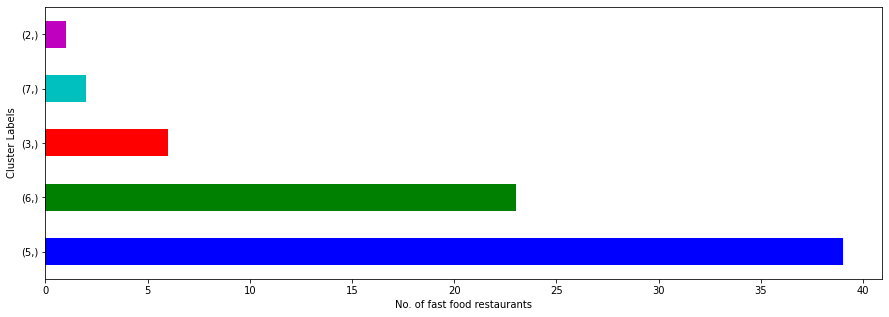

In [444]:
# Fast food restaurants in each cluster
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'g', 'b']

c_list[c_list['Venue Category'] == 'Fast Food Restaurant'][['Cluster Labels']].value_counts().plot.barh(color=colors, figsize=(15,5))
#plt.xticks(np.arange(0, 15, 5))
plt.xlabel('No. of fast food restaurants')

### <font color='red'> Observation 2 from below graph: Clusters 0, 1 and 4 population is very less so these cannot be good places to open restaurants. Hence we need to further review the clusters 2, 3, 6, 5, & 7

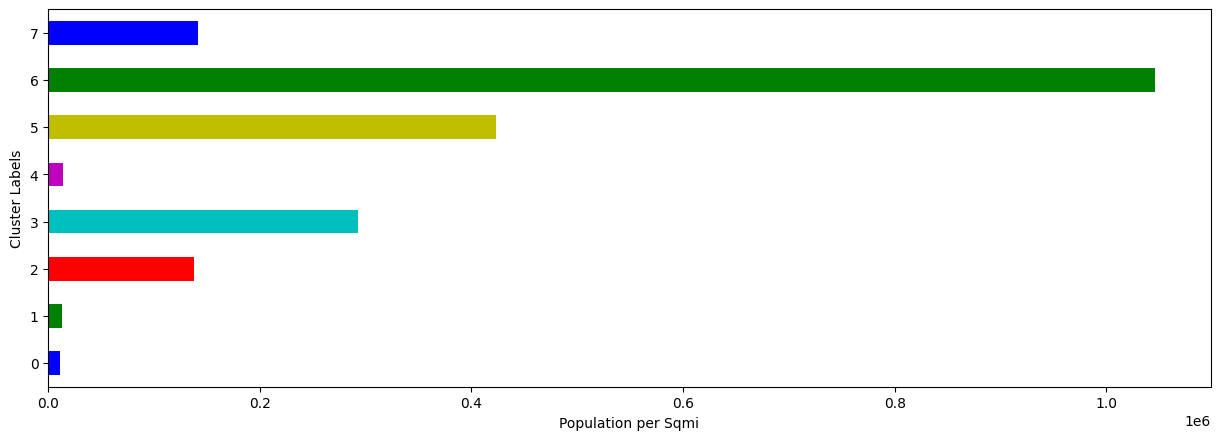

In [373]:
plt.figure(figsize=(9,5), dpi = 100)
plt.xlabel('Population per Sqmi')
neighbhorhoods_merged.sort_values(['Population per Sqmi'],ascending=False).groupby('Cluster Labels')['Population per Sqmi'].sum().head(20).plot.barh(color=colors, figsize=(15,5))
plt.show()

### <font color='teal'>Prep cluster data for scatter plots

In [528]:
x = pd.DataFrame(neighbhorhoods_merged.sort_values(['Population per Sqmi'],ascending=False).groupby('Cluster Labels')['Population per Sqmi'].sum())
y = pd.DataFrame(neighbhorhoods_merged.sort_values(['Restaurant Count'],ascending=False).groupby('Cluster Labels')['Restaurant Count'].sum())
x = x.reset_index()
y = y.reset_index()
s_data = x.merge(y, on='Cluster Labels')
s_data['Restaurant to Population Ratio'] = s_data['Restaurant Count'] / s_data['Population per Sqmi']
s_data.sort_values(['Restaurant to Population Ratio', 'Population per Sqmi'])

,Cluster Labels,Population per Sqmi,Restaurant Count,Restaurant to Population Ratio
4,4,14186,2,0.000141
0,0,10979,2,0.000182
2,2,137891,43,0.000312
3,3,293266,183,0.000624
7,7,142022,96,0.000676
1,1,12713,16,0.001259
5,5,423520,557,0.001315
6,6,1046242,2404,0.002298


### <font color='red'> Observation 3 from below graph: As you can see in the below scatter plot, Clusters 2 and 3 have very less number restaurants given the population density. Where cluster 5 and 6 already have good number of restaurants.

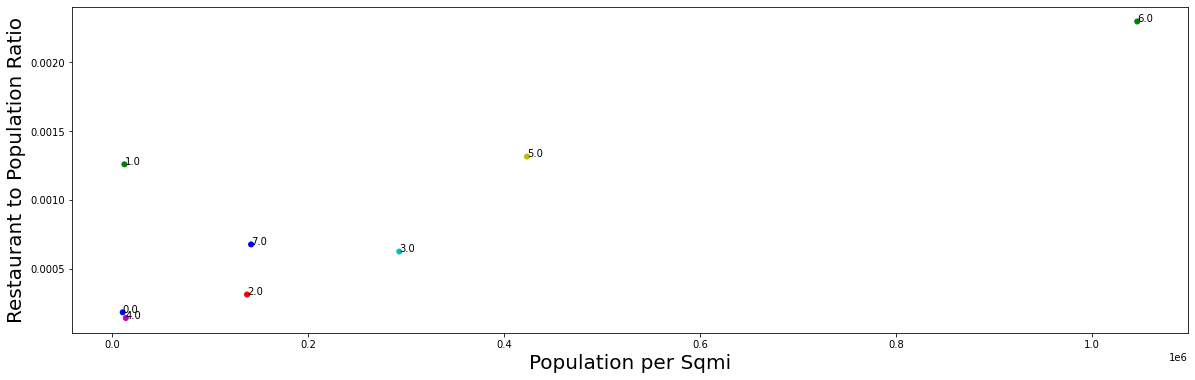

In [449]:
fig = plt.figure(1,figsize=(20,6))
plt.subplot(111)
plt.scatter(
    s_data['Population per Sqmi'],
    s_data['Restaurant to Population Ratio'],
    marker='o', color=colors, s=25)

for i, row in s_data.iterrows():
    plt.annotate(row["Cluster Labels"], xy=(row["Population per Sqmi"],row["Restaurant to Population Ratio"]))

plt.xlabel('Population per Sqmi',size=20)
plt.ylabel('Restaurant to Population Ratio',size=20)

plt.show()

### <font color='red'> Observation 4 from below table: With in Clusters 2 and 3, 'Lennox' neighborhood has least number of restaurants, given the population density. And there are no Fast food restaurants near by. Hence, it is the most suitable place to open a new fast food restaurant

In [508]:
# Look at cluster 2 & 3
neighbhorhoods_merged[(neighbhorhoods_merged['Cluster Labels'] == 2) | (neighbhorhoods_merged['Cluster Labels'] == 3)].sort_values(['Population per Sqmi'],ascending=False).head()

,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Fast Food Restaurant Count,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
112,South Bay,Lennox,33.939031,-118.357443,21557,9,0.0,3,Mexican Restaurant,Taco Place,Pizza Place,Seafood Restaurant,Food Truck,Middle Eastern Restaurant,Poke Place,Peruvian Restaurant,Persian Restaurant,Paella Restaurant
92,Southeast,Huntington Park,33.982704,-118.212034,20223,4,0.0,3,Fried Chicken Joint,Mexican Restaurant,Burger Joint,Food,African Restaurant,Moroccan Restaurant,Polish Restaurant,Poke Place,Pizza Place,Peruvian Restaurant
89,South L.A.,Historic South-Central,34.016230,-118.267308,19474,9,1.0,3,Mexican Restaurant,Restaurant,Taco Place,Fast Food Restaurant,Donut Shop,Seafood Restaurant,American Restaurant,Tex-Mex Restaurant,Tapas Restaurant,Peruvian Restaurant
33,South L.A.,Central-Alameda,34.004015,-118.247784,18760,4,0.0,3,Donut Shop,Taco Place,Food,Mexican Restaurant,African Restaurant,Mongolian Restaurant,Poke Place,Pizza Place,Peruvian Restaurant,Persian Restaurant
198,South L.A.,Vermont-Slauson,33.983691,-118.291542,18577,5,0.0,2,Food,Sandwich Place,Burger Joint,African Restaurant,Mongolian Restaurant,Poke Place,Pizza Place,Peruvian Restaurant,Persian Restaurant,Paella Restaurant


In [530]:
neighborhoods.sort_values(['Fast Food Restaurant Count'],ascending=False).head()

,Region,Neighborhood,Latitude,Longitude,Population per Sqmi,Restaurant Count,Fast Food Restaurant Count
53,San Gabriel Valley,Duarte,34.139451,-117.977287,3212,33,6.0
96,San Gabriel Valley,Irwindale,34.106993,-117.934215,154,18,5.0
59,San Gabriel Valley,East Pasadena,34.145351,-118.117545,4622,32,4.0
86,South Bay,Hawthorne,33.918859,-118.348326,13848,20,3.0
46,Southeast,Cudahy,33.962058,-118.183539,19697,12,3.0


## <div class="alert alert-block alert-info" style=" font-size: 20px">5. Conslusion: </div>

### Observations:
- Cluster 5 has most number of fast food restaurants, where as, cluster 2 has lowest.
- We can also notice that clusters 0, 1 and 4 do not have any fast food restaurants. However, population in these clusters is very less so these cannot be good places to open restaurants.
- Where in cluster 5 and 6 already have good number of restaurants so these are the potential good markets for fast food restaurants
- Clusters 2 and 3 have very less number restaurants given the population density so opening new restaurant near by these clusters will be a good option
- With in Clusters 2 and 3, 'Lennox' neighborhood has least number of restaurants, given the population density. And there are no Fast food restaurants near by. Therefore, it is the most suitable place to open a new fast food restaurant

#### Result:
##### We now answered all the questions from the problem statement
1) Which areas have potential Fast Food Restaurant Market? <br> <font color='green'> A) Clusters 5 and 6 have most number of restaurants
2) Which areas are lacking Fast Food Restaurants? <br> <font color='green'> A) Clusters 2 and 3 have very less number of fast food restaurants
3) What are the suitable neighborhoods in Los Angeles for opening a new Fast Food Restaurant? <br> <font color='green'> A) 'Lennox' from Cluster 3 is the most suitable place for a new fast food restaurant